In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
# from data_load import Data
# load = Data()
# load.HOMES_FOR_SALE()
# load.INCOME()
# load.HOMICIDES()
# load.POPULATION()
# load.ZIP_COUNTY()

In [3]:
from Final_Data_Output import Final_Data as FD
FD = FD()
clean_df = FD.Merge_all()                
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795743 entries, 0 to 795742
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   bed                 795743 non-null  float64
 1   bath                795743 non-null  float64
 2   house_size          795743 non-null  float64
 3   acre_lot            795743 non-null  float64
 4   zip_code            795743 non-null  float64
 5   Household_AGI       795743 non-null  float64
 6   Total_Pop           795743 non-null  float64
 7   Homicides           795743 non-null  float64
 8   bed_bath_ratio      795743 non-null  float64
 9   economic_health     795743 non-null  float64
 10  lot_to_house_ratio  795743 non-null  float64
 11  log_price           795743 non-null  float64
dtypes: float64(12)
memory usage: 72.9 MB


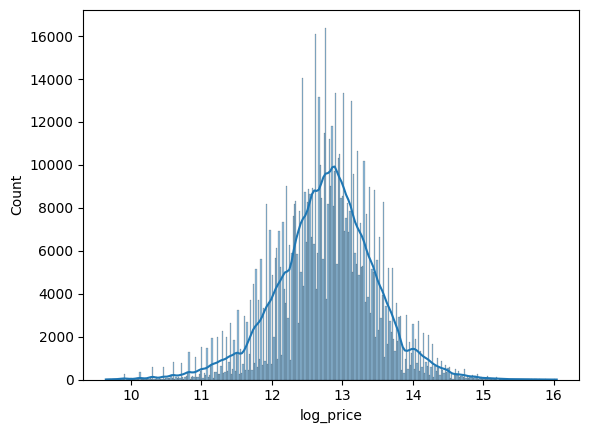

In [4]:
sns.histplot(clean_df['log_price'], kde=True)
plt.show()

In [5]:
from model_testing import Testing_Models as TM
tm = TM(clean_df.drop(columns=['log_price']), clean_df['log_price'])
glmm_mod = tm.GLMM()
glmm_mod

C:\Users\ej_la\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


{'error': 0.27593617340618465,
 'variance_explained': np.float64(0.8428880564311342),
 'y_pred': 222971    400290.260480
 417621    202749.590241
 38961     261741.088700
 642382    241043.122651
 653495    191241.952089
               ...      
 118620    276435.263631
 228982    309403.732280
 329673    449880.857707
 106059    591764.242664
 652033    244959.643219
 Length: 235039, dtype: float64,
 'model': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x19dc78ae270>,
 'scale_fit': StandardScaler()}

In [6]:
XGB_model = tm.XGBoost(gamma=0.09, learning_rate=0.063, colsample_bytree=0.72, subsample=0.71, max_depth=9, min_child_weight=1)
XGB_model

{'error': 0.24563976185973838,
 'variance_explained': np.float64(0.8754942921271681),
 'y_pred': array([458443.8 , 159879.22, 280064.47, ..., 490356.6 , 674504.6 ,
        314314.9 ], shape=(235039,), dtype=float32),
 'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.72, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.09, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.063, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_parallel_tree=None, ...),
 'scale_fit': Stand

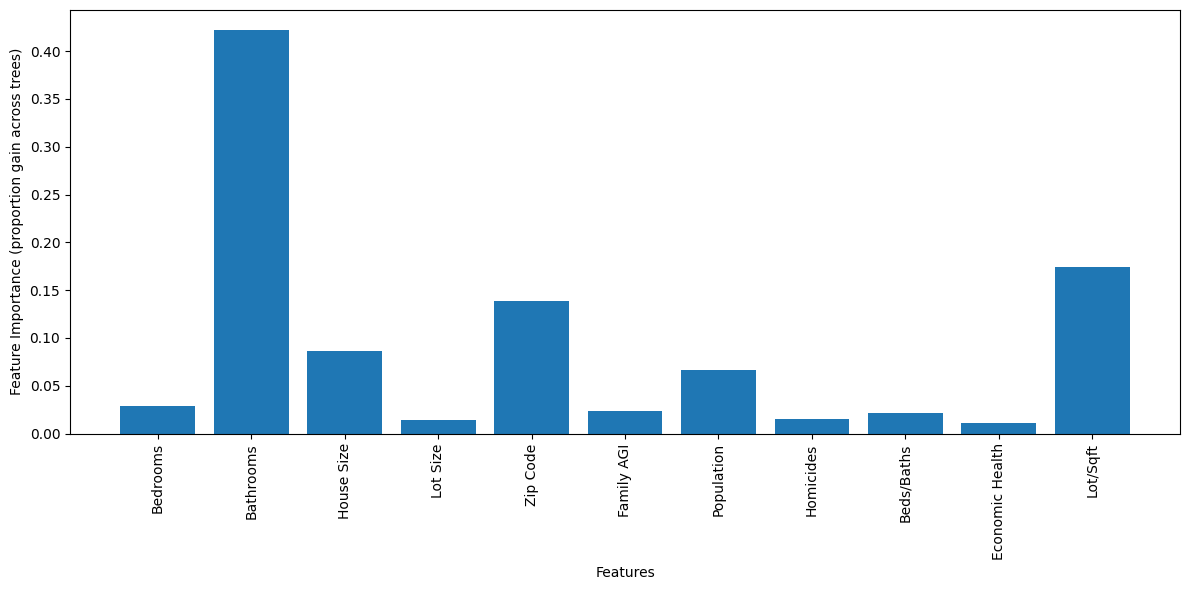

In [7]:
XGB_Features = pd.DataFrame({'Features': clean_df.drop(columns=['log_price']).columns, 'Weights': XGB_model['model'].feature_importances_})
original_features = clean_df.drop(columns=['log_price']).columns

label_map = {
    'bed': 'Bedrooms',
    'bath': 'Bathrooms',
    'house_size': 'House Size',
    'acre_lot': 'Lot Size',
    'zip_code': 'Zip Code',
    'Household_AGI': 'Family AGI',
    'Total_Pop': 'Population',
    'Homicides': 'Homicides',
    'bed_bath_ratio': 'Beds/Baths',
    'economic_health': 'Economic Health',
    'lot_to_house_ratio': 'Lot/Sqft'
}

labels = [label_map[col] for col in original_features]

x = np.arange(len(labels))

plt.figure(figsize=(12,6))
plt.bar(x, XGB_Features['Weights'])
plt.xticks(x, labels, rotation=90)
plt.ylabel('Feature Importance (proportion gain across trees)')
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('Feat_Import.png')
plt.show()

In [8]:
RF_model = tm.Random_Forest(max_depth=30, min_samples_split=2)
RF_model

{'error': 0.2837155532129116,
 'variance_explained': np.float64(0.8339043665897334),
 'y_pred': array([402691.85065322, 185201.56670203, 291938.65200038, ...,
        553101.36769021, 628234.91074235, 303588.42419117], shape=(235039,)),
 'model': RandomForestRegressor(max_depth=30, max_samples=0.05, n_estimators=400,
                       n_jobs=8, random_state=42),
 'scale_fit': StandardScaler()}

In [9]:
from Client_choice import Client_Opt as CO
client = CO(clean_df, XGB_model['model'], XGB_model['scale_fit'])
result = client.Client_prediction()
result.reset_index(inplace=True)
result.rename(columns = {'index': 'rank'}, inplace=True)

Chosen Bedrooms: 3
Chosen Bathrooms: 2
Chosen Square Footage: 1500
Chosen Square Footage: 0.25


In [10]:
result.to_json("zip_scores.json", orient="records")

In [11]:
result["zip_code"] = result["zip_code"].astype(int)
result["zip_code"] = result["zip_code"].astype(str)
zip_scores = {
    str(row["zip_code"]): {
        **row.drop("zip_code").to_dict(),
        "rank": int(row["rank"]),
        "Predicted_Price": float(row["Predicted_Price"]),
        "Total_Pop": int(row["Total_Pop"]),
        "Homicide_Rate": float(row["Homicide_Rate"]),
    }
    for _, row in result.iterrows()
}
json_str = json.dumps(zip_scores, indent=2)

js_str = f"const zipScores = {json_str};"
with open("zip_scores.js", "w") as f:
    f.write(js_str)
print(js_str)

const zipScores = {
  "63957": {
    "rank": 0,
    "bed": 3.0,
    "bath": 2.0,
    "house_size": 1500.0,
    "acre_lot": 0.25,
    "Household_AGI": 46.79844559585492,
    "Total_Pop": 5068,
    "Homicides": 0.0,
    "bed_bath_ratio": 1.2,
    "economic_health": 9.23228360541624,
    "lot_to_house_ratio": 7.26,
    "Predicted_Price": 83378.78125,
    "Homicide_Rate": 0.0
  },
  "26288": {
    "rank": 1,
    "bed": 3.0,
    "bath": 2.0,
    "house_size": 1500.0,
    "acre_lot": 0.25,
    "Household_AGI": 45.4954128440367,
    "Total_Pop": 2958,
    "Homicides": 0.0,
    "bed_bath_ratio": 1.2,
    "economic_health": 15.37526625347641,
    "lot_to_house_ratio": 7.26,
    "Predicted_Price": 83577.890625,
    "Homicide_Rate": 0.0
  },
  "26206": {
    "rank": 2,
    "bed": 3.0,
    "bath": 2.0,
    "house_size": 1500.0,
    "acre_lot": 0.25,
    "Household_AGI": 45.626666666666665,
    "Total_Pop": 2797,
    "Homicides": 0.0,
    "bed_bath_ratio": 1.2,
    "economic_health": 16.30688587086